## Prediction of Gout from patient's Chief Complaint Corpa

### A patient's verbal complaint is recorded by staff with each Emergency Room visit.  This machine learning model predicts if the patient is describing a potential "Gout" attack using local terms and vocabulary, alterting medical staff to this potential disease.  

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score

# NLP Libraries

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
#import scispacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy


# ONE-TIME DOWNLOADS
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download()

## Import Data
#### The data is found in the MIMIC-III (Medical Information Mart for Intensive Care III) database.  Details can be found at https://physionet.org/content/emer-complaint-gout/1.0/.   Acces to the database may be requested at (https://mimic.physionet.org/gettingstarted/access/).  The data is contained in 2 csv files from years 2019 and 2020.

In [2]:
syn2019 = pd.read_csv('Data/GOUT-CC-2019-CORPUS-SYNTHETIC.csv')
syn2020 = pd.read_csv('Data/GOUT-CC-2020-CORPUS-SYNTHETIC.csv')

The 3 columns contain the following data:
-  column 0: string text of the patient's chief complaint
-  column 1: string indicator indicating the prediction made by the ER Physician on the possibility of Gout
-  column 2: string indicator indicating the consensus result by the endocrinologist on the diagnosis of Gout

string indicator is a char of Y (yes), N (no), or - (unknown) 

In [3]:
print(syn2019.head())

                                     Chief Complaint Predict Consensus
0  "been feeling bad" last 2 weeks & switched BP ...       N         -
1  "can't walk", reports onset at 0830 am. orient...       Y         N
2  "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3  "gout flare up" L arm swelling x 1 week. denie...       Y         Y
4  "heart racing,"dyspnea, and orthopnea that has...       N         -


In [4]:
print(syn2020.head())

                                     Chief Complaint Predict Consensus
0  "I dont know whats going on with my head, its ...       N         -
1  "i've been depressed for a few weeks now, i'm ...       N         -
2  Altercation while making arrest, c/o R hand pa...       N         N
3  Cut on L upper thigh wtih saw. Bleeding contro...       N         N
4   Dysuria x1 week. hx: hysterectomy, gerd, bipolar       N         -


#### We don't have a need to separate years, date does not impact predictive quality so we will combine the files now, making cleaning and analysis easier.

In [5]:
# Combine the files into 1 dataframe
df = pd.concat([syn2019, syn2020], axis=0).reset_index(drop=True)
print(df.shape)

(8437, 3)


In [6]:
print(df.dtypes)

Chief Complaint    object
Predict            object
Consensus          object
dtype: object


In [7]:
print(df['Predict'].value_counts(sort=False))

-       2
N    8168
U     156
Y     111
Name: Predict, dtype: int64


In [8]:
print(df['Consensus'].value_counts(sort=False))

-    7976
N     350
U      16
Y      95
Name: Consensus, dtype: int64


#### Comparison of results for Predictions and Consensus

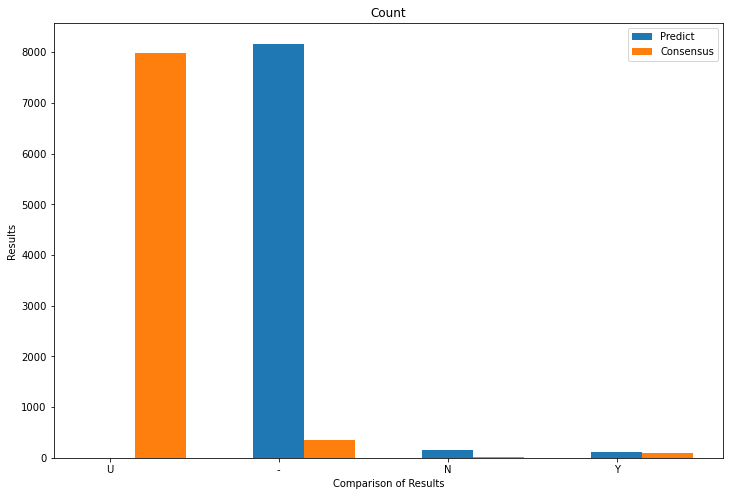

In [9]:
# Numbers of pairs of bars you want
N = 4
pred = df["Predict"].value_counts(sort=False)
cons = df["Consensus"].value_counts(sort=False)

# Position of bars on x-axis
ind = np.arange(N)

plt.figure(figsize=(12,8))
width = 0.3       

# Plotting
plt.bar(ind, pred , width, label='Predict')
plt.bar(ind + width, cons, width, label='Consensus')

plt.xlabel('Comparison of Results')
plt.ylabel('Results')
plt.title('Count')
plt.xticks(ind, ['U','-','N', 'Y'])

# Finding the best position for legends and putting it
plt.legend(loc="best")
plt.show()

In [10]:
print( df[(df.Consensus == '-') & (df.Predict == '-')])

                                        Chief Complaint Predict Consensus
7799  Right lower back pain that radiates down leg t...       -         -
7857  pain to posterior upper leg x 3 days, seen at ...       -         -


In [11]:
df2 = df[(df.Consensus != '-') & (df.Predict != '-')]
print(df2['Predict'].value_counts())

N    213
U    154
Y     94
Name: Predict, dtype: int64


In [12]:
print(df2['Consensus'].value_counts())

N    350
Y     95
U     16
Name: Consensus, dtype: int64


# For each record containing null or unknowns in both columns - remove.

# Manually compare remaining nulls and unknowns in Consensus, replace with predicted value?

#### Review the target values and remove nulls, in this case "U" is considered a null value

In [13]:
df['Predict'].value_counts()

N    8168
U     156
Y     111
-       2
Name: Predict, dtype: int64

In [14]:
df['Consensus'].value_counts()

-    7976
N     350
Y      95
U      16
Name: Consensus, dtype: int64

/opt/anaconda3/envs/mimicnlp2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


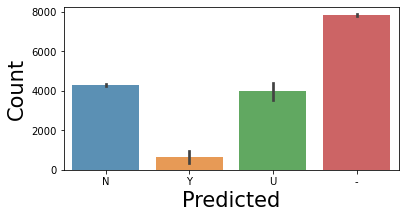

In [15]:
plt.figure(figsize=(6,3))
sns.barplot(df['Predict'].values, df['Predict'].index, alpha=0.8)
plt.ylabel('Count', fontsize=21)
plt.xlabel('Predicted', fontsize=21)
plt.show()

/opt/anaconda3/envs/mimicnlp2/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


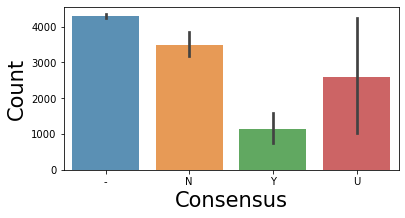

In [16]:
plt.figure(figsize=(6,3))
sns.barplot(df['Consensus'].values, df['Consensus'].index, alpha=0.8)
plt.ylabel('Count', fontsize=21)
plt.xlabel('Consensus', fontsize=21)
plt.show()

###  The Consensus is the column validated by a endocrinologist, confirming Gout or not.  This will be our target.  The Null values ('-') are therefore removed for the initial model.  More exploration of 

In [17]:
df = df[df['Consensus']!= "-"]
df = df[df['Predict']!= "-"]
df = df[df['Consensus']!= "U"]
df = df[df['Predict']!= "U"]
df.shape

(303, 3)

In [18]:
print(df.dtypes)

Chief Complaint    object
Predict            object
Consensus          object
dtype: object


In [19]:
df['Predict'].value_counts()

N    209
Y     94
Name: Predict, dtype: int64

In [20]:
df['Consensus'].value_counts()

N    223
Y     80
Name: Consensus, dtype: int64

### Remove digits: 
#### the text commonly contains many descriptions such as number of times a patient takes medication, etc and will add noise to the model.  

In [21]:
pattern = r'[0-9]'

In [22]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x: re.sub(pattern, '', x))
print(df.head(20))

                                      Chief Complaint Predict Consensus
1   "can't walk", reports onset at  am. oriented x...       Y         N
2   "dehydration" Chest hurts, hips hurt, cramps P...       Y         Y
3   "gout flare up" L arm swelling x  week. denies...       Y         Y
5   "I started breathing hard"  hx- htn, gout, anx...       N         N
6   "I think I have a gout flare up" L wrist pain ...       Y         Y
7   "I want to see if I have an infection" pt vagu...       Y         N
8   "My gout done flared up on me", c/o R ankle, L...       Y         Y
9   "my gout is hurting me"- reports bilateral foo...       Y         Y
11        "umbearable" right foot/ankle pain pmh gout       Y         Y
12  (LMC) transfer for renal transplant. pt SOB x ...       N         N
14  (JI) dizziness and SOB. recent HTN med change ...       N         N
15  (RM) intermittent cp since this am, worse duri...       N         N
17  (Grandview tx) neck pain and right arm pain fo...       N   

### Tokenize sentences

In [23]:
tokenizer = RegexpTokenizer("[\w']+")

In [24]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x: tokenizer.tokenize(x.lower()))

### Remove stop words

In [25]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [26]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x : remove_stopwords(x))
df['Chief Complaint'].head()
df

,Chief Complaint,Predict,Consensus
1,"[can't, walk, reports, onset, oriented, x, aor...",Y,N
2,"[dehydration, chest, hurts, hips, hurt, cramps...",Y,Y
3,"[gout, flare, l, arm, swelling, x, week, denie...",Y,Y
5,"[started, breathing, hard, hx, htn, gout, anxi...",N,N
6,"[think, gout, flare, l, wrist, pain, swelling,...",Y,Y
...,...,...,...
8424,"[sob, right, chest, pain, x, weeks, hx, multip...",N,N
8425,"[starts, lower, back, goes, right, legs, x, mo...",N,N
8427,"[sciatica, pain, r, lower, back, radiating, r,...",N,N
8432,"[stepped, nail, home, right, foot, painful, di...",N,N


### Perform lemmatization

In [27]:
lemmatizer = WordNetLemmatizer()

In [28]:
def word_lemmatizer(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [29]:
df['Chief Complaint'].apply(lambda x: word_lemmatizer(x))

1       [can't, walk, report, onset, oriented, x, aort...
2       [dehydration, chest, hurt, hip, hurt, cramp, p...
3       [gout, flare, l, arm, swelling, x, week, denie...
5       [started, breathing, hard, hx, htn, gout, anxi...
6       [think, gout, flare, l, wrist, pain, swelling,...
                              ...                        
8424    [sob, right, chest, pain, x, week, hx, multipl...
8425    [start, lower, back, go, right, leg, x, month,...
8427    [sciatica, pain, r, lower, back, radiating, r,...
8432    [stepped, nail, home, right, foot, painful, di...
8436    [rash, sore, across, body, infection, ro, left...
Name: Chief Complaint, Length: 303, dtype: object

### Perform stemming

In [30]:
stemmer = PorterStemmer()

In [31]:
def word_stemmer(text):
    stem_text = ' '.join([stemmer.stem(i) for i in text])
    return stem_text

In [32]:
df['Chief Complaint'] = df['Chief Complaint'].apply(lambda x: word_stemmer(x))
df

,Chief Complaint,Predict,Consensus
1,can't walk report onset orient x aortic valv r...,Y,N
2,dehydr chest hurt hip hurt cramp pmh hip repla...,Y,Y
3,gout flare l arm swell x week deni pmh,Y,Y
5,start breath hard hx htn gout anxieti,N,N
6,think gout flare l wrist pain swell sinc hx af...,Y,Y
...,...,...,...
8424,sob right chest pain x week hx multipl back su...,N,N
8425,start lower back goe right leg x month chiropr...,N,N
8427,sciatica pain r lower back radiat r groin x wk...,N,N
8432,step nail home right foot pain difficult walk ...,N,N


## Analysis

### Top 10 Nouns contained in the text

In [33]:
# split into sentences && flatten nested lists
sentences = [nltk.pos_tag(s.split()) for s in df['Chief Complaint']]
flat_s = [item for sublist in sentences for item in sublist]

# get nouns from tagged words
nouns = [(word, tag) for word, tag in flat_s if any(noun_tag in tag for noun_tag in ['NP', 'NN'])]

# build frequency distribution for nouns
nouns_freq = nltk.FreqDist([word for word, tag in nouns])

# view top 10 occuring nouns
nouns_freq.most_common(10)

[('gout', 227),
 ('pain', 215),
 ('htn', 134),
 ('pmh', 120),
 ('x', 98),
 ('pt', 90),
 ('day', 73),
 ('c', 68),
 ('dm', 58),
 ('week', 55)]

### Vectorize data for modeling

In [34]:
predict = df.Predict
print(predict.value_counts())

N    209
Y     94
Name: Predict, dtype: int64


In [35]:
concensus = df.Consensus
print(concensus.value_counts())

N    223
Y     80
Name: Consensus, dtype: int64


In [36]:
X_train, X_test, y_train, y_test = train_test_split(df['Chief Complaint'], predict, test_size=0.33, random_state=55)

In [37]:
count_vectorizer = CountVectorizer(stop_words='english')

In [38]:
count_train = count_vectorizer.fit_transform(X_train)

In [39]:
count_test = count_vectorizer.transform(X_test)

In [40]:
print(count_vectorizer.get_feature_names()[:10])

['abd', 'abdomen', 'abdomin', 'abl', 'abnorm', 'abus', 'abx', 'accept', 'accid', 'ach']


In [41]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(df['Chief Complaint'])
X = pd.DataFrame.sparse.from_spmatrix(vectorized, columns=vectorizer.get_feature_names())

## Attempting Logistic Regression & Plot

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
# convert both sets' text column to document-term matrix
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# train the mutinomial naive bayes model, 
# predict on the test set and output the accuracy score
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy:', accuracy)

# train the logistic regression model, 
# predict on the test set and output the auc score
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

accuracy: 0.85
auc 0.9701426024955436


In [43]:
def vis_coef(estimator, feature_names, topn = 10):
    fig = plt.figure()
    n_classes = estimator.coef_.shape[0]
    feature_names = np.asarray(feature_names)
    for idx, coefs in enumerate(estimator.coef_, 1):
        sorted_coefs = np.argsort(coefs)
        positive_coefs = sorted_coefs[-topn:]
        negative_coefs = sorted_coefs[:topn]
        top_coefs = np.hstack([negative_coefs, positive_coefs])

        colors = ['#A60628' if c < 0 else '#348ABD' for c in coefs[top_coefs]]
        y_pos = np.arange(2 * topn)
        fig.add_subplot(n_classes, 1, idx)
        plt.barh(y_pos, coefs[top_coefs], color = colors, align = 'center')
        plt.yticks(y_pos, feature_names[top_coefs])
        plt.title('top {} positive/negative coefficient'.format(topn))

    plt.tight_layout()

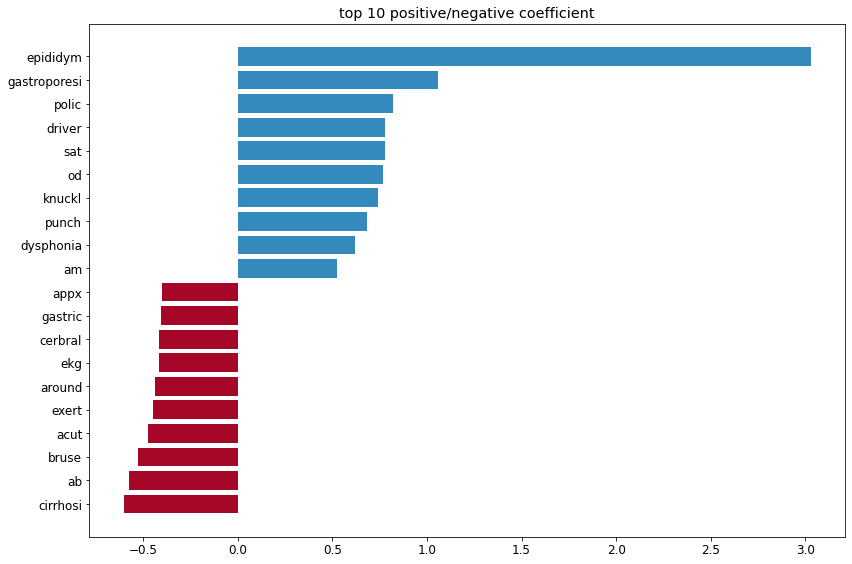

In [44]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 12

feature_names = vectorizer.get_feature_names()
coef_plot = vis_coef(logreg, feature_names, topn = 10)
plt.show()

### Tf-idf vectorization

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])


['abd', 'abdomen', 'abdomin', 'abl', 'abnorm', 'abus', 'abx', 'accept', 'accid', 'ach']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Run Nultinomial Naive Bayes Prediction

In [52]:
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.73


### Confusion Matrix: 0=Gout, 1 = non-Gout
#### Below is seen 0 false negatives, 27 False Positive

In [53]:
# Plots confusion matrix of model

def plot_confusion(y_test, pred):
    mat = confusion_matrix(y_test, pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true')
    plt.ylabel('predicted')

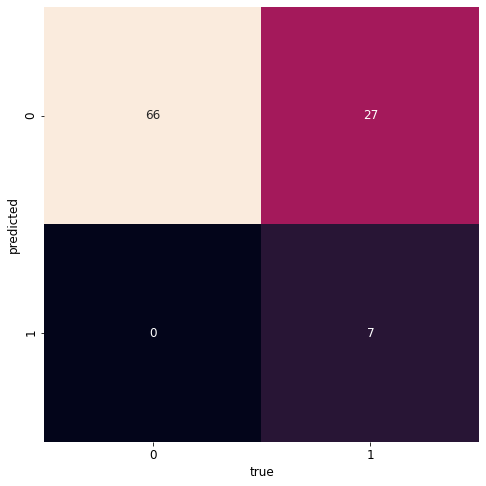

In [54]:
plot_confusion(y_test, pred)
plt.show()

### Tune model: testing 'alpha' hyper parameter

In [55]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.78

Alpha:  0.1
Score:  0.87

Alpha:  0.2
Score:  0.81

Alpha:  0.30000000000000004
Score:  0.8

Alpha:  0.4
Score:  0.79

Alpha:  0.5
Score:  0.76

Alpha:  0.6000000000000001
Score:  0.75

Alpha:  0.7000000000000001
Score:  0.76

Alpha:  0.8
Score:  0.74

Alpha:  0.9
Score:  0.74



/opt/anaconda3/envs/mimicnlp2/lib/python3.8/site-packages/sklearn/naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


### Classifier coefficients
#### Interesting to see the terms associated with Gout and terms indicating non-gout

In [56]:
neg_class_prob_sorted = nb_classifier.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = nb_classifier.feature_log_prob_[1, :].argsort()[::-1]

print("Top 10 words indicating Gout: ",np.take(count_vectorizer.get_feature_names(), pos_class_prob_sorted[:10]))
print("Least likely to indicate Gout: ",np.take(count_vectorizer.get_feature_names(), neg_class_prob_sorted[:10]))


Top 10 words indicating Gout:  ['gout' 'pain' 'knee' 'swell' 'foot' 'hx' 'htn' 'day' 'week' 'pmh']
Least likely to indicate Gout:  ['pain' 'pmh' 'htn' 'gout' 'pt' 'day' 'deni' 'right' 'chest' 'dm']
